# Statistical power and sample size

## Introduction

Statistical significance, as indicated by a P value below a chosen threshold, is a cornerstone of hypothesis testing. However, it only reveals one side of the coin - the likelihood of observing a result as extreme as or more extreme than the one obtained, assuming the null hypothesis is true. It doesn't tell us the _probability of missing a true effect_, nor does it quantify the magnitude of that effect.

This is where the concept of **statistical power** takes center stage. Power is the _probability of finding a statistically significant result when a true effect exists_. It's a measure of our ability to detect real phenomena and distinguish them from random noise.

In this chapter, we'll delve into the intricacies of statistical power, exploring its relationship to type I and type II errors, the factors that influence it (effect size, sample size, variability), and how to calculate and interpret it. We'll also provide practical guidance on how to use power analysis to make informed decisions about sample size, ensuring the studies are adequately powered to answer research questions.

## Definitions

### The power

The **power (1 - β)** of an experimental design answers this crucial question: if there truly is an effect of a specified size, and the experiment is repeated many times, what proportion of those experiments will yield a statistically significant result? This concept is essential for determining sample size requirements and for interpreting results that are not statistically significant.

While the definition of a P value starts with the assumption that the null hypothesis (H0) is true, we often want to know what happens when H0 is false, and there is a real effect. Statistical power addresses this by asking: if a specific effect truly exists (e.g., a difference between groups, a relative risk, a correlation), what is the probability of obtaining a statistically significant result in a single experiment?

Power is the proportion of hypothetical experiments (if we were to repeat our study many times) in which we would expect to correctly reject the null hypothesis, given that the alternative hypothesis (the effect we're looking for) is actually true

|                     | Decision: reject H0 | Decision: fail to reject H0 |
|:------------------- |:-------------------:|:---------------------------:|
| No effect (H0 True) | Type I error (α)    | Correct decision (1 - α)    |
| Effect exists       | 1 - β               | Type II error (β)           |

<img src="https://static.wingify.com/gcp/uploads/sites/3/2020/12/graphical-representation-of-type-1-and-type-2-errors.png" alt="type I and type II errors seen in H0 and H1 distributions" style="width: 500px;"/>

Since β represents the probability of one outcome (failing to reject a false H0), 1 - β represents the probability of the complementary outcome (correctly rejecting a false H0). This complementary outcome is what we define as statistical power.

In general, experiments with high statistical power are characterized by:

- Large sample sizes: more data points provide greater precision and reduce the impact of random variation.
- Large effect sizes: the greater the magnitude of the effect we're looking for, the easier it is to detect.
- Low variability (scatter): less variability within our data makes it easier to distinguish a true signal from noise.

And when there is no true effect (the null hypothesis is true), power tends to be as low as the chosen significance level (often 5%). However, as the true effect size increases (while keeping sample size and variability constant), power increases in a sigmoidal (S-shaped) curve, theoretically reaching 100%. This means that with a large enough effect, we're virtually guaranteed to detect it.

### The effect size

Statistical significance (P < α) tells us if an observed effect is likely not due to chance. However, it doesn't reveal how large or meaningful the effect is. This is where **effect size** comes in. Effect size is a standardized measure of the magnitude of a phenomenon, allowing us to compare the strength of effects across different studies, even when they use different scales or measures.

One of the most common measures of effect size for comparing two groups is **Cohen's $d$**.  It quantifies the difference between two group means in terms of their _pooled standard deviation_ ($s_p$):

$$d = \frac{\overline{X} - \overline{Y}}{s_p} = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1) s_{2}^{2}}{n1 + n2 - 2}}}$$

For a comparison between 2 groups with the _same sample size_ ($n_1 = n_2 = n$), and the _same variance_ ($s_1^2 = s_2^2 = s^2$), often referred to as the **homoscedasticity** or equal variance assumption, e.g., in controlled experiments, matched pairs designs or random sampling from a homogeneous population, the equation can be simplified to:

$$d = \frac{\overline{X} - \overline{Y}}{\sqrt{\frac{\cancel{2 (n - 1)} s^2}{\cancel{2 (n - 1)}}}} = \frac{\overline{X} - \overline{Y}}{s}$$

Cohen's d values are typically interpreted as follows:

| Effect | d   |
| ------ | --- |
| Small  | 0.2 |
| Medium | 0.5 |
| Large  | 0.8 |

We can calculate effect size between two sets of observations with [`pingouin.compute_effsize`](https://pingouin-stats.org/build/html/generated/pingouin.compute_effsize.html).

## Relationship between power, effect size, sample size, and variability

Statistical power is not a single, fixed value. It's a dynamic concept influenced by several key factors: the size of the effect we're looking for, the amount of variability in the data, and the sample size of our study. In this section, we'll use simulations to visualize how these factors interact and impact the power of a statistical test.

### One-sample t-test

**Statistical power calculations** can be used to determine the sample size needed to detect if a sample mean is significantly different from a known population mean or a hypothesized value, for example how many patients need to be enrolled in a study to determine if a new drug significantly reduces blood pressure compared to a baseline value. It can also be used to determine the number of pairs needed to detect a significant difference between two measurements taken on the same subjects, e.g., how many participants should be included in a study to assess if a new therapy significantly improves cognitive function compared to their pre-treatment scores.

To put these power calculations into practice, we can leverage Python's statsmodels library, which provides convenient tools for power analysis. The [`TTestPower`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestPower.html) function within this library allows us to estimate the required sample size for _one-sample and paired t-tests_, given the desired power, significance level, and anticipated effect size. For example, a pharmaceutical company aims to determine if their new drug can significantly lower cholesterol levels. They plan to conduct a clinical trial with a one-sample t-test, comparing the mean cholesterol level of patients taking the new drug to the known population mean.

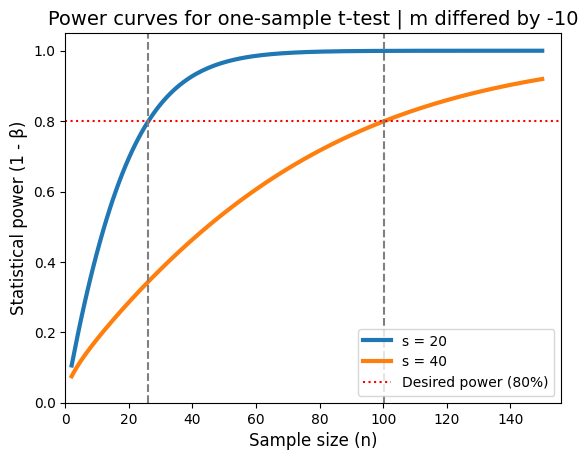

In [20]:
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestPower

# Simulation parameters
diff = -10            # Mean level **decrease** compared to known population mean
std_devs = [20, 40]   # Different levels of standard deviation
power = 0.8           # Desired power (80%)
alpha = 0.05          # Significance level
max_sample_size = 151 # Sample sizes to consider

# Calculate power curves
power_analysis = TTestPower()

power_curves = {}
for sd in std_devs:
    power_curves[sd] = [
        power_analysis.power(
            effect_size=diff/sd,
            alpha=alpha,
            nobs=n,
            alternative='smaller',
        ) for n in range(2, max_sample_size)]  # Start from 2 observations
    
# Calculate required sample sizes for each SD
required_sample_sizes = {}
for sd in std_devs:
    required_sample_sizes[sd] = power_analysis.solve_power(
        effect_size=diff/sd,
        power=power,
        alpha=alpha,
        nobs=None, # this is the one we want to solve
        alternative='smaller')

# Plotting
# plt.figure(figsize=(10, 6))
for sd, powers in power_curves.items():
    plt.plot(
        range(2, max_sample_size),
        powers,
        label=f's = {sd}',
        lw=3)

plt.axhline(
    y=power,
    ls=':', c='red',
    label=f'Desired power ({power*100:.0f}%)')

for sd, powers in required_sample_sizes.items():
    plt.axvline(
        required_sample_sizes[sd],
        linestyle='--',color='gray',
        # label=f'N for power=0.8, SD={sd}',
    )

plt.xlabel("Sample size (n)", fontsize=12)
plt.ylabel("Statistical power (1 - β)", fontsize=12)
plt.title(
    f"Power curves for one-sample t-test | m differed by {diff}",
    fontsize=14)
plt.legend()
# plt.grid(axis='y', linestyle='--')
plt.xlim(0, max_sample_size+5)
plt.ylim(0, 1.05);

This plot illustrates how increasing standard deviation (greater variability in the data) lowers the statistical power for a given sample size and effect size. To maintain a desired level of power when dealing with higher variability, we need to increase the sample size, because [effect size and variance are inversely related](effect-size).

The plot is also a valuable tool for planning studies. It helps us determine the appropriate sample size needed to detect a specific effect with a desired level of confidence, given the expected variability in the data. If our study didn't find a significant result, this plot can help us assess whether it was due to a lack of a true effect or simply a lack of power (insufficient sample size). Finally, by understanding the relationship between power, sample size, and variability, we can allocate the research resources more efficiently, avoiding underpowered studies that are unlikely to yield meaningful results.

### Unpaired t-test

Power calculations for independent t-tests serve a crucial role in experimental design and interpretation of results. Their primary purpose is to determine the minimum sample size needed in each group to detect a statistically significant difference between the means of two independent groups, with a specified level of confidence. In the following example, we the [`TTestIndPower`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.html) function for analyzing statistical power in the context of _independent two-sample t-tests_. In particular, the `plot_power` function within provides a convenient way to visualize the relationship between power, the effect size and sample size in a _two-sample t-test_ scenario.

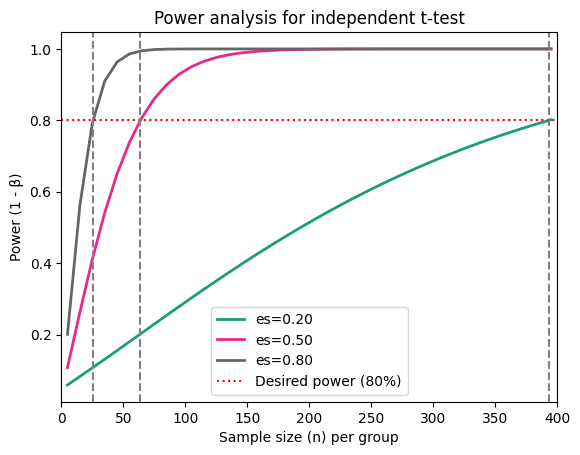

In [21]:
import numpy as np
from statsmodels.stats.power import TTestIndPower

# Analysis setup
power_analysis = TTestIndPower()
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.arange(5, 401, 10)
alpha = 0.05
power = 0.8  # Desired power (80%)

# Calculate required sample sizes for each SD
required_sample_sizes = {}
for es in effect_sizes:
    required_sample_sizes[es] = power_analysis.solve_power(
        effect_size=es,
        power=power,
        alpha=alpha,
        # parameters are a little different than in TTestPower
        ratio=1, # ratio nobs2 over nobs1
        nobs1=None, # this is the one we want to solve
        alternative='two-sided')

# Plotting with plot_power function
power_analysis.plot_power(
    dep_var='nobs',
    nobs=sample_sizes,
    effect_size=effect_sizes,
    alpha=alpha)

plt.axhline(
    y=power,
    ls=':', c='red',
    label=f'Desired power ({power*100:.0f}%)')

for es, powers in required_sample_sizes.items():
    plt.axvline(
        required_sample_sizes[es],
        linestyle='--',color='gray',
        # label=f'N for power=0.8, SD={sd}',
    )

plt.xlabel('Sample size (n) per group')
plt.ylabel('Power (1 - β)')
plt.xlim(0, max(sample_sizes)+5)
plt.title('Power analysis for independent t-test')
plt.legend();

Each curve corresponds to a different effect size, showing how power increases with sample size for that particular effect. The curves have a characteristic sigmoidal (S-shaped) pattern, reflecting how power initially increases rapidly with sample size and then levels off. Finally, larger effect sizes lead to steeper curves, meaning they require smaller sample sizes to achieve the same level of power.

In conclusion, as the sample size per group increases, so does the power to detect a statistically significant difference between the means. This means _larger samples are more likely to identify a true effect_, as demonstrated in the figure below.

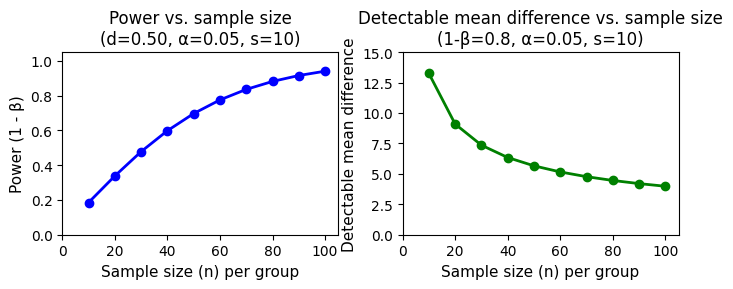

In [22]:
# Parameters
alpha = 0.05                          # Significance level
power = 0.8                           # Desired power
sd = 10                               # Standard deviation
mean_difference = 5                   # Mean difference tested
sample_sizes = np.arange(10, 101, 10) # Range of sample sizes per group

# Power analysis for subplot 1
power_analysis = TTestIndPower()
powers = [
    power_analysis.power(
        effect_size=mean_difference/sd,
        alpha=alpha,
        nobs1=n,
        ratio=1,
    ) for n in sample_sizes]

# Calculate mean differences for subplot 2
mean_diffs = [
    power_analysis.solve_power(
        effect_size=None,
        power=power,
        alpha=alpha,
        nobs1=n,
        ratio=1.0,
    # multiply the solved effect size by SD to get the mean difference
    )*sd for n in sample_sizes]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(7, 3)) # 1 row, 2 columns

# Subplot 1: Power vs. Sample Size
axes[0].plot(
    sample_sizes, powers,
    'o-', color='blue', linewidth=2)
axes[0].set_xlabel('Sample size (n) per group', fontsize=11)
axes[0].set_ylabel('Power (1 - β)', fontsize=11)
axes[0].set_title(
    "Power vs. sample size\n"
    f"(d={mean_difference/sd:.2f}, α={alpha}, s={sd})",
    fontsize=12)
# axes[0].grid(axis='y', linestyle='--')
axes[0].set_xlim(0, max(sample_sizes)+5)
axes[0].set_ylim(0, 1.05)

# Subplot 2: Mean Difference vs. Sample Size
axes[1].plot(
    sample_sizes, mean_diffs,
    'o-', color='green', linewidth=2)
axes[1].set_xlabel('Sample size (n) per group', fontsize=11)
axes[1].set_ylabel('Detectable mean difference', fontsize=11)
axes[1].set_title(
    "Detectable mean difference vs. sample size\n"  # Implicit string concatenation
    f"(1-β={power}, α={alpha}, s={sd})",
    fontsize=12)
# axes[1].grid(axis='y', linestyle='--')
axes[1].set_xlim(0, max(sample_sizes)+5)
axes[1].set_ylim(0, 15)

plt.tight_layout();

### Paired t-test

Let's dive into a concrete example of power calculation for a _paired t-test_ using the Pingouin package in Python.

The [`power_ttest` method](https://pingouin-stats.org/build/html/generated/pingouin.power_ttest.html) provides a single function that can calculate power, sample size, effect size, or significance level, depending on which parameters are provided. It handles one-sample, paired-sample, and two-sample independent t-tests with equal sample sizes (for unequal sample sizes, use [`power_ttest2n`](https://pingouin-stats.org/build/html/generated/pingouin.power_ttest2n.html), though it does not solve the number of observations). However, `pingouin.power_ttest` doesn't directly create plots like `statsmodels.stats.power` classes and methods do.

Imagine a biotech is studying the effectiveness of a new cognitive training program aimed at improving memory scores. It plans to administer a memory test to participants _before and after_ the training program. Researchers want to determine the sample size needed to have an 80% chance (power = 0.8) of detecting a statistically significant improvement in memory scores after the training.

Required sample sizes for 80% power in a paired t-test:
Effect size = 0.2: 199 pairs
Effect size = 0.5: 34 pairs
Effect size = 0.8: 15 pairs


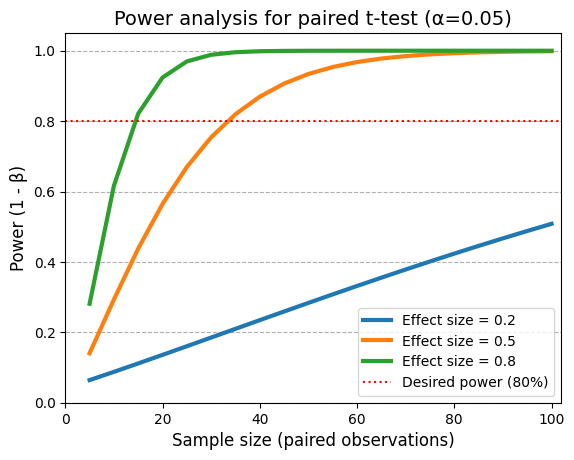

In [23]:
import pingouin as pg

# Parameters
effect_sizes = np.array([0.2, 0.5, 0.8]) # Different effect sizes (Cohen's d)
alpha = 0.05                             # Significance level
sample_sizes = np.arange(5, 101, 5)      # Sample sizes/number of pairs to consider
power = 0.8                              # Desired power (80%)

# Calculate and print required sample sizes
print("Required sample sizes for 80% power in a paired t-test:")
for es in effect_sizes:
    required_n = pg.power_ttest(
        d=es,
        n=None, # parameter to solve
        power=power,
        alpha=alpha,
        contrast='paired',
        alternative='two-sided')
    print(f"Effect size = {es}: {int(np.ceil(required_n))} pairs") # type: ignore

# Plotting
# plt.figure(figsize=(10, 6))
for es in effect_sizes:
    power_values = pg.power_ttest(
        d=es,
        n=sample_sizes,
        power=None, # parameter we want to solve
        alpha=alpha,
        contrast='paired',
        alternative='two-sided', # default
    )

    plt.plot(
        sample_sizes,
        power_values, # type: ignore
        # 'o-',
        label=f'Effect size = {es:.1f}',
        lw=3)

plt.axhline(
    y=power,
    ls=':', c='red',
    label=f'Desired power ({power*100:.0f}%)')

plt.xlabel('Sample size (paired observations)', fontsize=12)
plt.ylabel('Power (1 - β)', fontsize=12)
plt.title(
    f"Power analysis for paired t-test (α={alpha})",
    fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.xlim(0, max(sample_sizes)+2)
plt.ylim(0, 1.05);

The curves clearly demonstrate that power increases as the sample size per group increases. This means that with larger samples, we have a higher probability of detecting a statistically significant difference between the groups, even if the true effect size is small.

Furthermore, each curve represents a different level of standard deviation (SD) within the groups. As the SD increases (i.e., the data becomes more spread out), the curves shift to the right. This means we need a larger sample size to achieve the same level of power when the data is more variable.

## Choosing a sample size

### The choice of 80% power

The horizontal dashed line at 0.8 in the previous plots represents the commonly desired power level of 80%. The 80% power standard emerged as a compromise between type I and type II errors. In the early days of statistical practice, limited resources and computational power made it difficult to achieve very high power. A power of 80% was seen as a reasonable balance, offering a good chance of detecting a real effect without requiring excessively large sample sizes.

Setting power too low (e.g., 60%) increases the risk of type II errors (e.g., 40%), meaning we're more likely to miss a true effect. On the other hand, striving for very high power (e.g., 99%) often demands much larger sample sizes, which may not be feasible or ethical in many research settings. If the consequences of a type II error (missing a real effect) are severe, we might opt for a higher power level, even if it means a larger sample size. For example, in a clinical trial for a life-saving drug, a higher power (e.g., 90%) might be preferred.

80% power strikes a middle ground, offering a reasonable probability of detecting an effect while keeping sample size requirements manageable. In early-stage research or pilot studies, a lower power level (e.g., 70%) might be acceptable, as the goal is often to gather preliminary evidence rather than draw definitive conclusions. Also, if we have strong _prior evidence suggesting the presence of an effect_, we might be comfortable with lower power. Don't to forget that if we expect a very large effect size, we might be able to achieve adequate power with a smaller sample size. However, it's still important to conduct a power analysis to confirm this.

### Tools for power calculations

As we've seen, sample size calculations for a desired level of statistical power require to specify the following:

- Significance level (α): the acceptable risk of a false positive (type I error).
- Desired power (1 - β): the desired probability of correctly detecting a true effect.
- Minimum effect size: the smallest effect size we consider meaningful and worth detecting.
- Standard deviation (s): a measure of the variability or scatter in the data. Alternatively, for proportion-based tests, we would need the expected proportion.

The type of test (one-tailed or two-tailed) also affects sample size calculations. One-tailed tests generally require smaller sample sizes but are only appropriate when we have a strong directional hypothesis. Importantly, power analysis formulas often rely on _assumptions_ about the distribution of the data (e.g., normality). Violating these assumptions can affect the accuracy of the calculations.

Numerous online tools and software packages can assist with power analysis. Some popular options include:

- [G*Power](https://www.gpower.hhu.de) for comparing means
- [Power and Sample Size](https://www.powerandsamplesize.com), for comparing means, K means, proportions, time-to-event data, odds ratio, etc.
- R packages such as [`pwr`](https://github.com/heliosdrm/pwr) and [`simr`](https://github.com/pitakakariki/simr) that offer comprehensive power analysis functions within the R statistical environment
- Python libraries `statsmodels`, with the `solve_power` method from the `TTestPower` and `TTestIndPower` classes, and `pingouin` with `power_ttest`, as we have seen in our previous examples. The `statsmodels` library offers another option with the direct function import of [`tt_ind_solve_power`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html).

For example, the required sample size per group to achieve 80% power in detecting a 17 kg mean difference between men and women, given a standard deviation of 17 kg and a significance level of 0.05 can be obtained as follows.

In [24]:
from statsmodels.stats.power import tt_ind_solve_power

# Parameters
effect_size = 17 / 17  # Cohen's d (mean_diff / polled_sd)
alpha = 0.05           # Significance level
desired_power = 0.8    # Target power

# Calculate sample size (directly)
n_per_group = tt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=desired_power,
    ratio=1.0,          # Equal sample sizes
    alternative='two-sided')

# Display result (clear and concise)
print(f"Required sample size per group: {int(np.ceil(n_per_group))}")

Required sample size per group: 17


If we collect weights from 17 men and 17 women in many experiments, assuming the standard deviation of 17 kg is close to the true population SD, we'd expect approximately 80% of those experiments to yield statistically significant results (P < 0.05). This is because our power analysis indicated that a sample size of 17 per group is sufficient to achieve 80% power to detect a mean difference of 17 kg with this SD.

Important Considerations:

- Assumption of Equal Variance (Homoscedasticity): this calculation assumes that the _variances_ in the men and women groups are _equal_. If we have reason to believe the variances might be different, we should use a different power analysis function or adjust the calculation accordingly.
- Assumption of Normality: the power analysis and the interpretation of the results rely on the assumption that the weight data are _normally distributed_ within each group. If this assumption is violated, the results might not be accurate.
- Standard Deviation: the _standard deviation_ of 17 kg is an estimate. It's crucial to have a _reliable estimate_ of this value, either from prior studies or pilot data.
- Effect Size: the chosen effect size of 1.0 (17 kg / 17 kg) is considered a _large effect_. If we expect a smaller effect, we will need a larger sample size to achieve the same power.

### The simulation-based approach

While traditional power analysis methods (like those we've discussed) rely on theoretical formulas and assumptions, a simulation-based approach offers a more flexible and intuitive way to estimate sample size.

Here's how it works:

1. Define the study design: clearly articulate the research question, the type of study (e.g., randomized controlled trial, observational study), and the primary outcome measure.
2. Simulate data under H0: generate multiple datasets under the assumption that the null hypothesis is true (no effect). We can use distributions (e.g., normal, binomial) that mimic the expected characteristics of the data.
3. Simulate data under H1: generate multiple datasets under the assumption that the alternative hypothesis is true, using an effect size we consider clinically meaningful.
4. Analyze and compare: perform the planned statistical test (e.g., t-test, chi-squared) on each simulated dataset. Compare the proportion of significant results under H0 (false positives) to the proportion under Ha (true positives) for various sample sizes.
5. Determine sample size: choose the smallest sample size where the proportion of true positives is acceptably high (e.g., 80% power) while keeping the proportion of false positives at or below the chosen significance level (e.g., 5%).

As a practical example, let's say we're designing a study to evaluate a new drug's effect on systolic blood pressure. We hypothesize that the drug will reduce systolic blood pressure by 10 mmHg compared to a placebo. We want to determine the sample size needed to have an 80% chance of detecting this effect.

In [25]:
from scipy.stats import ttest_ind

# For reproducibility
np.random.seed(111)

def simulate_study(n, mean_difference=0):
    control_group = np.random.normal(130, 15, n)  # Mean = 130, SD = 15
    treatment_group = np.random.normal(130 - mean_difference, 15, n)
    _, p_value = ttest_ind(control_group, treatment_group)
    return p_value < 0.05 # type: ignore
    # True if significant, False otherwise

# Simulation parameters
mean_difference = 10
alpha = 0.05
power = 0.8
num_simulations = 1000 # Number of simulations
max_sample_size = 80   # Max number of samples per group

# Run simulations
results = []
# Iterate over sample sizes, starting from 10, up to the max_sample_size, in steps of 5
for n in range(10, max_sample_size, 5):
    # Simulate num_simulations (1000 in this case) studies for the current sample size (n)
    # The simulate_study function returns True for significant results (p < 0.05)
    signif_results = sum(
        simulate_study(n, mean_difference=mean_difference) for _ in range(num_simulations))

    # Calculate the power as the proportion of simulations that resulted in a significant finding
    power = signif_results / num_simulations

    # Store the current sample size and the calculated power for later
    results.append((n, power))

# Find the smallest sample size that achieves 80% power
for n, power in results:
    if power >= 0.8:
        print(f"Required sample size per group: {n}")
        break

Required sample size per group: 35


This simulation would run t-tests on randomly generated data and find the minimum sample size needed to detect the hypothesized effect with 80% power. While it can handle **complex study designs** and **various outcome distributions**, especially when normality assumptions don't hold, it can be **computationally intensive** for large simulations.

### Comparing proportions (A/B test)

We can use a simplified formula derived from the principles of hypothesis testing for proportions, assuming the sample proportions follow a normal distribution, and incorporating the desired power and significance level:

$$n=(z_{\alpha/2}+z_\beta)^2 \times \frac{p_1(1-p_1)+p_2(1-p_2)}{(p_1-p_2)^2}$$

The term $(p_1 - p_2)$ represents the effect size, i.e., the difference in proportions we want to detect, $z_{\alpha/2}$ is the z-score corresponding to the significance level ($\alpha$) divided by 2 which defines the critical region in each tail of the distribution where we would reject the null hypothesis (here it's a two-sided test), also noted as $z^\ast$, and $z_\beta$ is the z-score corresponding to the desired power which defines the distance between the alternative hypothesis distribution and the critical region.

We can also use the [`samplesize_proportions_2indep_onetail` function](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.samplesize_proportions_2indep_onetail.html) which uses an explicit computation to find sample size.

Some methods calculate power and sample size based on exact statistical distributions (like the binomial distribution for proportions), while others use approximations (like the normal approximation to the binomial). These approximations might introduce _slight discrepancies_, especially with smaller sample sizes. Furthermore, the specific numerical algorithms used to solve for power and sample size can vary between functions, leading to slight differences in the results. There are more sophisticated methods available (e.g., using the binomial distribution directly) for complex scenarios or when precise calculations are required.

In [26]:
from scipy.stats import norm

# parameters
p2= 5/100   # baseline proportion, e.g., complication rate
p1 = 3/100  # 2% absolute change, i.e., from 5% to 3%
alpha = 0.05
power = .9

# Calculate sample size using manual calculations
za = norm.ppf(1-(alpha/2))
zb = np.abs(norm.ppf(1-power))

n_per_group_manual = (za+zb)**2 * (p1*(1-p1) + p2*(1-p2)) / (p1-p2)**2

# Calculate sample size using statsmodels
from statsmodels.stats.proportion import samplesize_proportions_2indep_onetail
n_per_group_statsmodels = samplesize_proportions_2indep_onetail(
    diff=-2/100,  # here p1 = prop2 + diff
    prop2=5/100,  # here prop2 is the proportion for the reference
    power=power,
    ratio=1,
    alpha=alpha)

# Display results
print(f"Required sample size per group (using manual calculations): \
{int(np.ceil(n_per_group_manual))}")
print(f"Required sample size per group (using statsmodels): \
{int(np.ceil(n_per_group_statsmodels))}")


Required sample size per group (using manual calculations): 2013
Required sample size per group (using statsmodels): 2016


## Complexities when computing sample size

### Incorporating FPRP into sample size decisions

The False Positive Report Probability (FPRP) can be estimated before conducting an experiment based on the chosen significance level, desired power, and the prior probability of the null hypothesis (H0) being true.

As shown in the next table, the FPRP is dramatically affected by the prior probability:

- 1% Prior Probability: this represents a _highly speculative scenario_ with _little evidence_ to support the alternative hypothesis. In this case, a significant result has an 86.1% chance of being a _false positive_. Less than 1% of significant results would be true positives.
- 50% Prior Probability: when there's solid theoretical or empirical backing for the alternative hypothesis, the FPRP drops significantly to 5.9%. This suggests a _much higher likelihood_ of a significant result being a _true discovery_.

In [27]:
alphas = [.05, .01, .001]     # significance levels tested
powers = [.80, .90, .95, .99] # power levels tested
pprobas= [0.01, 0.1, .25, .5] # estimates of prior probability

print("FPRP affected by α, power, and prior probability\n")

print(f"α\tpower\t{100*pprobas[0]}%\t{100*pprobas[1]}%\t{100*pprobas[2]}%\t{100*pprobas[3]}%")
print("-"*45, end='')

for alpha in alphas:
    print(f"\n{alpha:4.3f}", end="")
    
    for power in powers:
        print(f"\n\t{100*power}%", end="")
        
        for proba in pprobas:
            print(f"\t{100*((1-proba)*alpha)/(((1-proba)*alpha)+(proba*power)):3.1f}%", end="")

FPRP affected by α, power, and prior probability

α	power	1.0%	10.0%	25.0%	50.0%
---------------------------------------------
0.050
	80.0%	86.1%	36.0%	15.8%	5.9%
	90.0%	84.6%	33.3%	14.3%	5.3%
	95.0%	83.9%	32.1%	13.6%	5.0%
	99.0%	83.3%	31.3%	13.2%	4.8%
0.010
	80.0%	55.3%	10.1%	3.6%	1.2%
	90.0%	52.4%	9.1%	3.2%	1.1%
	95.0%	51.0%	8.7%	3.1%	1.0%
	99.0%	50.0%	8.3%	2.9%	1.0%
0.001
	80.0%	11.0%	1.1%	0.4%	0.1%
	90.0%	9.9%	1.0%	0.3%	0.1%
	95.0%	9.4%	0.9%	0.3%	0.1%
	99.0%	9.1%	0.9%	0.3%	0.1%

In essence, a study's context is crucial. A well-designed experiment with a high prior probability of a true effect can yield reliable significant findings, while a speculative study with low prior probability is more likely to produce misleading results.

Therefore, it's imperative to consider the prior probability when designing and interpreting studies. When faced with a low prior probability, researchers should adjust their expectations and potentially employ stricter significance thresholds or gather additional evidence to strengthen the credibility of their findings.

### Guidance for making informed sample size decisions

While power analysis provides a valuable framework for calculating sample size, the process is rarely straightforward. Several factors can influence the accuracy and applicability of our calculations:

- Choosing the significance level α
  - Think beyond tradition: don't blindly default to the conventional α = 0.05.
  - Prior probability matters: consider the **prior probability** of a true effect (pre-study evidence).
  - FPRP as a guide: estimate the False Positive Report Probability (FPRP) to understand the **risk of false positives**.
  - One-tailed vs. two-tailed: choose the appropriate test directionality based on the research question.
- Choosing desired statistical power (1 - β)
  - Balance the FPRP: aim for a power level that, in combination with the chosen α, results in a **reasonably low FPRP**.
  - Weigh the consequences: consider the relative costs of type I and type II errors. If **missing a true effect** is very costly, opt for higher power.
- Selecting the effect size
  - Scientific relevance: focus on the **smallest effect size** that would be **scientifically meaningful**, not just statistically significant.
  - Don't rely solely on published estimates: published effect sizes might be biased or not relevant to our specific context.
  - Consider standard effect sizes: use **Cohen's guidelines** (e.g., 1/5th the SD, or 0.2 → small, half the SD, or 0.5 → medium, 0.8 → large) as a starting point, but don't blindly adhere to them.
  - Don't anchor on the expectations: base the sample size on the effect size we want to detect, not necessarily what we expect to find.
  - Think in ratios: if estimating the exact effect size is difficult, consider framing it as a _ratio relative to the standard deviation_ (e.g., "we want to detect an effect size equal to half the SD").
- Estimating expected variability
  - Minimize variability: if possible, design the study to **reduce the variability** within groups (e.g., through stricter inclusion criteria, more controlled experimental conditions).
  - Pilot studies: conduct **pilot studies** to get a realistic estimate of variability. Small pilot studies often underestimate true variability as seen in the table below.
  - Published estimates with caution: be aware that published standard deviations might be biased downward due to selective reporting.
- Planning for unequal sample sizes
  - Trade-offs: if we need to reduce the sample size in one group, we should be prepared to increase the other group's size even more to maintain power.
  - Statistical guidance: consult a statistician for optimal strategies in dealing with unequal group sizes.
- Accounting for dropouts
  - Anticipate attrition: always overestimate the sample size to account for potential dropouts during the study.
  - Retention strategies: consider strategies to minimize dropout rates to preserve statistical power.
- Leveraging paired designs
  - Increased power: if the study design allows for pairing observations (e.g., pre- and post-test measures), take advantage of it! **Paired t-tests are more powerful** than independent t-tests for the same effect size.
  - Sample size adjustment: the required sample size for a paired t-test is typically smaller than that for an unpaired test, but keep in mind that we'll need twice the number of total observations (one for each member of the pair).

### Underestimation of the true variability

The discrepancy between a sample's standard deviation $s$ and the true population SD (σ) can be substantial, particularly when dealing with small sample sizes. For example, with a sample size of only 3, σ could be up to 6.28 times larger than the sample SD (s), as reflected in the confidence interval for the SD. Since the required sample size for a t-test is proportional to the square of the SD, if the SD obtained in a pilot study is half the true population SD, the calculated sample size would be merely one-quarter of what it should be.

In [28]:
from scipy.stats import chi2

def W(n, alpha=1 - 0.95):
    t2=chi2(df=n-1).ppf(alpha/2)
    t1=chi2(df=n-1).ppf(1-(alpha/2))
    return np.sqrt((n-1)/t1), np.sqrt((n-1)/t2)
    
sample_sizes = [2, 3, 5, 10, 25, 50, 100, 500, 1000]

print("n\t95% CI of SD")
print("--------------------------", end='')

for sample_size in sample_sizes:
    print(f"\n{sample_size}", end="")
    print(f"\t{W(sample_size)[0]:.2f}×SD - {W(sample_size)[1]:05.2f}×SD", end="")

n	95% CI of SD
--------------------------
2	0.45×SD - 31.91×SD
3	0.52×SD - 06.28×SD
5	0.60×SD - 02.87×SD
10	0.69×SD - 01.83×SD
25	0.78×SD - 01.39×SD
50	0.84×SD - 01.25×SD
100	0.88×SD - 01.16×SD
500	0.94×SD - 01.07×SD
1000	0.96×SD - 01.05×SD

This highlights the importance of using caution when relying on pilot studies or _small samples_ to estimate variability for power analysis. It underscores the value of obtaining **reliable estimates of the population standard deviation**, either from larger pilot studies, previous research, or expert knowledge. When such information is unavailable, conservative estimates of variability or adjustments to sample size calculations should be considered to avoid underpowered studies.

## Conclusion

We've learned that power is not a mere theoretical abstraction but a practical tool that empowers researchers to make informed decisions about the scale and scope of their studies. By understanding the factors that influence power and utilizing the computational resources available in Python, we can design experiments that are both efficient and reliable.

We've also highlighted the importance of considering the false positive report probability (FPRP), especially in the context of low prior probability, to temper our enthusiasm for statistically significant results and ensure that our findings are truly meaningful.

The tools and techniques discussed here are not just for statisticians; they are essential for any researcher seeking to extract reliable insights from data. By embracing the principles of power analysis, we can move beyond simple P-values and towards a more nuanced understanding of the evidence supporting our scientific claims.

## Cheat sheet

This cheat sheet provides a quick reference for essential code snippets used in this chapter.


### Sample size and statistical power for one-sample t-test

```python
import numpy as np
from statsmodels.stats.power import TTestPower

diff = -10         # mean level **decrease** compared to known population
sd = 20            # (pooled) standard deviation
power = 0.8        # desired power (80%)
alpha = 0.05       # significance level

power_analysis = TTestPower()

power_analysis.solve_power(
    effect_size=diff/sd,
    power=power,
    alpha=alpha,
    nobs=None,     # number of observations (to solve)
    alternative='smaller',
) # use np.ceil to round the result
```

### Sample size and statistical power for paired t-test

```python
diff = 10          # mean difference
sd = 20            # (pooled) standard deviation
power = 0.8        # desired power (80%)
alpha = 0.05       # significance level

power_analysis = TTestPower()

power_analysis.solve_power(
    effect_size=diff/sd,
    power=power,
    alpha=alpha,
    nobs=None,     # number of pairs (to solve)
    alternative='two-sided',
) # use np.ceil to round the result
```

### Sample size and statistical power for unpaired two-sample t-test

```python
from statsmodels.stats.power import TTestIndPower

es = 0.5           # effect size
power = 0.8        # desired power (80%)
alpha = 0.05       # significance level

power_analysis = TTestIndPower()

power_analysis.solve_power(
    effect_size=es,
    power=power,
    alpha=alpha,
    # parameters are a little different than in TTestPower
    ratio=1,       # ratio nobs2 over nobs1
    nobs1=None,    # number of observations in first sample (to solve)
    alternative='two-sided',
) # use np.ceil to round the result

# Equivalent to 
from statsmodels.stats.power import tt_ind_solve_power

# Calculate sample size per group
tt_ind_solve_power(
    effect_size=es,
    nobs1=None,    # (to solve)
    alpha=alpha,
    power=power,
    ratio=1.0,     # with nobs2 = nobs1 * ratio
    alternative='two-sided'
) # use np.ceil to round the result
```

### Power analysis plot

```python
sample_sizes = np.arange(10, 501, 10)

# Work exactly the same for TTestPower and TTestIndPower
power_analysis.plot_power(
    dep_var='nobs',
    nobs=sample_sizes,
    effect_size=[-.2, -.5, -.8],
    alpha=alpha,
    alternative='two-sided',
)
```

### Sample size and statistical power with pingouin

```python
import pingouin as pg

es = 0.5
alpha = 0.05
power = 0.8

# For one-sample, paired and unpaired two-samples (with **equal sizes**) t-tests
pg.power_ttest(
    d=es,
    n=None,         # parameter to solve
    power=power,
    alpha=alpha,
    contrast='paired', # choice between 'paired', 'one-sample' and 'two-samples'
    alternative='two-sided',
) # use np.ceil to round the result
```

### A/B test

```python
from statsmodels.stats.proportion import samplesize_proportions_2indep_onetail

p2= 5/100           # baseline proportion, e.g., complication rate
p1 = 3/100          # 2% absolute change, i.e., from 5% to 3%
alpha = 0.05
power = .9

samplesize_proportions_2indep_onetail(
    diff=-2/100,    # with p1 = prop2 + diff
    prop2=5/100,    # prop2 is the proportion for the reference/baseline
    power=power,
    ratio=1,
    alpha=alpha,
)  # use np.ceil to round the result
```

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [29]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'scipy', 'pingouin', 'statsmodels', 'matplotlib', 'seaborn']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.7
-------------
numpy: 1.26.4
scipy: 1.14.1
pingouin: 0.5.5
statsmodels: 0.14.2
matplotlib: 3.9.2
seaborn: 0.13.2
